In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
import sklearn.linear_model as linear_model
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
%matplotlib inline
import sklearn.metrics as metrics
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor


/Users/erikgreenj/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Step 1: Define the problem
-We'd like to use existing data we have about previous homes that were sold in Aimes, Iowa to help us predict how much future homes could potentially sell for.  We need to build a model that most accurately predicts the value of a home in Aimes.  We will measure the accuracy of our model using Root Mean Squared Error (RMSE.)

### Step 2:  Gather data
-This data has been gathered for us.  We just need to import.<br>
-Also, it's good practice to make copies before we explore and delete/change things.

In [2]:
data = pd.read_csv('../project-2/data/train.csv')

In [3]:
test = pd.read_csv('../project-2/data/test.csv')

In [4]:
testindex = test.index

## Step 3: Explore data
### Clean

-This data has many columns, so we set our display to show them all.

In [5]:
pd.set_option('display.max_columns', 500)

In [6]:
#view the first few rows and see all column names.
data.head(2)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000


In [7]:
#fix column names to make them easier to work with
#We'll be doing the same things to our data and test sets for here on out, 
#to make sure that our model fits correctly and is accurate
data.columns = data.columns.str.replace(' ', '_')
data.columns = data.columns.str.lower()
test.columns = test.columns.str.replace(' ', '_')
test.columns = test.columns.str.lower()

In [8]:
#view which columns are numerical
#describe only returns numerical columns, so we can use describe() to filter
d = data.describe()
d.columns

Index(['id', 'pid', 'ms_subclass', 'lot_frontage', 'lot_area', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'mas_vnr_area',
       'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area',
       'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath',
       'bedroom_abvgr', 'kitchen_abvgr', 'totrms_abvgrd', 'fireplaces',
       'garage_yr_blt', 'garage_cars', 'garage_area', 'wood_deck_sf',
       'open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch',
       'pool_area', 'misc_val', 'mo_sold', 'yr_sold', 'saleprice'],
      dtype='object')

In [9]:
#2051 rows, 81 columns
data.shape

(2051, 81)

In [10]:
#get info for numerical columns
#data.describe()

In [11]:
#check for nulls

nulls = data.isnull().sum()

nullst = test.isnull().sum()

In [12]:
nulls[nulls > 0][:3]

lot_frontage     330
alley           1911
mas_vnr_type      22
dtype: int64

In [13]:
nullst[nullst > 0][:3]

lot_frontage    160
alley           821
mas_vnr_type      1
dtype: int64

In [14]:
#after seeing this, I feel comfortable in dropping the following columns because so few rows are filled:
#alley, pool_qc.
#will misc_feature
data = data.drop(['alley', 'pool_qc'], axis=1)
test = test.drop(['alley', 'pool_qc'], axis=1)

In [15]:
#now, we're going to replace NaN values in categorical columns with 'NONE'
#This will allow them to be categorized together if we decide to make dummies with the feature later

#make a mask for non-numericals with a list comprehension
mask1 = [x for x in data.columns if x not in data.describe().columns]

#will return all categorical columns with Nans
cat_cols_with_nan = data[mask1].isnull().sum()[data[mask1].isnull().sum() != 0]

#used the above mask and look the index, made a list
mask1_nans = list((cat_cols_with_nan).index)



In [16]:
#checking if we can use the same mask for test set later on
mask1_nans, test[mask1].isnull().sum()[data[mask1].isnull().sum() != 0]
#we can!


#the mask will change as nulls are full though, need to either set a function to update, or not use mask

(['mas_vnr_type',
  'bsmt_qual',
  'bsmt_cond',
  'bsmt_exposure',
  'bsmtfin_type_1',
  'bsmtfin_type_2',
  'fireplace_qu',
  'garage_type',
  'garage_finish',
  'garage_qual',
  'garage_cond',
  'fence',
  'misc_feature'],
 mas_vnr_type        1
 bsmt_qual          25
 bsmt_cond          25
 bsmt_exposure      25
 bsmtfin_type_1     25
 bsmtfin_type_2     25
 fireplace_qu      422
 garage_type        44
 garage_finish      45
 garage_qual        45
 garage_cond        45
 fence             707
 misc_feature      838
 dtype: int64)

In [17]:
#Python can be finicky when you try to replace within a slice.  This is likely because it can be interpreted in 2 ways
#so we had to use a loop through the original dataFrame
for x in data:
    if x in mask1_nans:
        data[x].replace({np.nan : 'None'}, inplace=True)   
        
        #note the difference between None and 'None'.  We made a string so they will be categorized together.
        #'None' is a placeholder and could be any string.  In practice, I might set it to something unconventional,
        #to let others know whats going on
        

In [18]:
#Now we repeat this for the test set.  We use the same mask, but in a different case, we may have to make a new one.
for x in test:
    if x in mask1_nans:
        test[x].replace({np.nan : 'None'}, inplace=True)

In [19]:
#return the rest of the null values
data.isnull().sum()[data.isnull().sum() != 0]

lot_frontage      330
mas_vnr_area       22
bsmtfin_sf_1        1
bsmtfin_sf_2        1
bsmt_unf_sf         1
total_bsmt_sf       1
bsmt_full_bath      2
bsmt_half_bath      2
garage_yr_blt     114
garage_cars         1
garage_area         1
dtype: int64

In [20]:
#starting with garage_area, because there is only one value missing
data[data['garage_area'].isnull()]
#we inspect this row and see that it does have a garage (garage_type = Detchd).  
#Also, we notice that garage_cars and area are NaN.  We're going to replace these values manually, with iloc

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
1712,2237,910201180,70,RM,50.0,9060,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,None,Detchd,NaN,None,NaN,NaN,None,None,Y,174,0,212,0,0,0,MnPrv,None,0,3,2007,WD,150909


In [21]:
#get the indexes to replace with iloc
#note that if we dropped any rows, this method may replace the wrong value.  
#so was careful replacing this one and checked before permanently replacing
list(data.columns).index('garage_area'), list(data.columns).index('garage_cars')

(62, 61)

In [22]:
#replacing with means shouldn't throw things off too badly.
#will replace garage yr built with year house was built

data.iloc[1712, 62] = data.garage_area.mean()

data.iloc[1712, 61] = data.garage_cars.mean()

data.iloc[1712, 59] = 1923

In [23]:
#checking in with test for nulls
test.isnull().sum()[test.isnull().sum() != 0]

lot_frontage     160
mas_vnr_area       1
electrical         1
garage_yr_blt     45
dtype: int64

In [24]:
#the reason why you keep seeing this twice, is because we're setting a bool condition to data.isnull().sum()
data.isnull().sum()[data.isnull().sum() != 0]

lot_frontage      330
mas_vnr_area       22
bsmtfin_sf_1        1
bsmtfin_sf_2        1
bsmt_unf_sf         1
total_bsmt_sf       1
bsmt_full_bath      2
bsmt_half_bath      2
garage_yr_blt     113
dtype: int64

In [25]:
#next, let's check out mas_vnr_area
data[data.mas_vnr_area.isnull()][['gr_liv_area', 'mas_vnr_area','mas_vnr_type']].head(2)

,gr_liv_area,mas_vnr_area,mas_vnr_type
22,2253,NaN,None
41,2076,NaN,None


In [26]:
#switch mas_vnr_area to 0s if nan

#This variable is MasVnrArea: Masonry veneer area in square feet.  if nan, there's probably no Masonry Veneer.

data['mas_vnr_area'].replace({np.nan : 0}, inplace=True)

In [27]:
#switch mas_vnr_area to 0s if nan in test
test['mas_vnr_area'].replace({np.nan : 0}, inplace=True)

In [28]:
data.isnull().sum()[data.isnull().sum() != 0]

lot_frontage      330
bsmtfin_sf_1        1
bsmtfin_sf_2        1
bsmt_unf_sf         1
total_bsmt_sf       1
bsmt_full_bath      2
bsmt_half_bath      2
garage_yr_blt     113
dtype: int64

In [29]:
#The reason why we inspect these elements along with garage_yr_blt is to help decide the best way to handle the null
data[data.garage_yr_blt.isnull()][['garage_yr_blt', 'garage_area', 'garage_cars', 'garage_type']].head(2)

,garage_yr_blt,garage_area,garage_cars,garage_type
28,NaN,0.0,0.0,None
53,NaN,0.0,0.0,None


In [30]:
data['garage_yr_blt'].fillna(data['year_built'], inplace=True)
test['garage_yr_blt'].fillna(test['year_built'], inplace=True)

In [31]:
data[data.bsmtfin_sf_1.isnull()]
#looks like row 1327 doesn't have a basement
#we'll fix these cells manually

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
1327,1342,903230120,20,RM,99.0,5940,Pave,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,None,None,None,None,NaN,None,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,None,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,MnPrv,None,0,4,2008,ConLD,79000


In [32]:
list(data.columns).index('bsmt_full_bath')

47

In [33]:
data.iloc[1327, 34] = 0
data.iloc[1327, 36] = 0
data.iloc[1327, 37] = 0
data.iloc[1327, 38] = 0
data.iloc[1327, 47] = 0
data.iloc[1327, 48] = 0

In [34]:
data.isnull().sum()[data.isnull().sum() != 0]

lot_frontage      330
bsmt_full_bath      1
bsmt_half_bath      1
dtype: int64

In [35]:
data[data.bsmt_full_bath.isnull()]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
616,1498,908154080,20,RL,123.0,47007,Pave,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1959,1996,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,Slab,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,Y,SBrkr,3820,0,0,3820,NaN,NaN,3,1,5,1,Ex,11,Typ,2,Gd,Attchd,1959.0,Unf,2.0,624.0,TA,TA,Y,0,372,0,0,0,0,None,None,0,7,2008,WD,284700


In [36]:
data.iloc[616, 47] = 0
data.iloc[616, 48] = 0

In [37]:
data.iloc[616, 47]

0.0

### Replacing lot_frontage

In [38]:
#lot_frontage is last to fix.
#going to check for highest correlation for lot_frontage
data[data.lot_frontage.notnull()]

corr_lot_frontage = data[data.lot_frontage.notnull()].corr()

corr_lot_frontage = abs(corr_lot_frontage.lot_frontage)

corr_lot_frontage = pd.DataFrame(corr_lot_frontage)

corr_lot_frontage = corr_lot_frontage.sort_values(by='lot_frontage', ascending=False)

corr_lot_frontage.head(4)

#closest is lot area, but only 0.57 corr

,lot_frontage
lot_frontage,1.000000
lot_area,0.574024
1st_flr_sf,0.463900
ms_subclass,0.389790


In [39]:
####not sure  what the best course is for lot frontage.  maybe can take a mean and add noise??  
####we're not likely to use this category in our predictive models


####settled on grouping by ms_subclass and using the mean lot_frontage to fill nulls. 

####will make a column with avg lot_frontage grouped by ms_subclass and replace nulls

In [40]:
#started by making a dict to pair avgs with ms_subclass
front_dict = (data.groupby(['ms_subclass'], as_index=False).mean().groupby('ms_subclass')['lot_frontage'].mean())
#front_dict

In [41]:
ms_subclass = list(front_dict.index)

In [42]:
frontage = list(front_dict)
#frontage

In [43]:
#manually replacing nan in frontage with overall lot_frontage mean.
#doing this manually because loops and list comprehensions keep throwing errors
frontage = [77.03286384976526,
 61.04347826086956,
 51.75,
 54.81818181818182,
 63.0,
 78.26948051948052,
 64.32142857142857,
 70.46666666666667,
 79.87301587301587,
 73.33333333333333,
 69.39682539682539,
 44.81651376146789,
 data.lot_frontage.mean(),
 27.5875,
 26.6,
 71.6046511627907]
    
        

In [44]:
front_dict = dict(zip(ms_subclass,frontage))
#front_dict

In [45]:
#made a new list and inserted in 
ms_subclass_avg_front = []
for x in data.ms_subclass:
    ms_subclass_avg_front.append(front_dict[x])

data.insert(loc=4, column='ms_subclass_avg_front', value=ms_subclass_avg_front)

data.lot_frontage.replace(np.nan, data.ms_subclass_avg_front, inplace=True)

### Now do lot frontage for test

In [46]:
front_dict_t = (test.groupby(['ms_subclass'], as_index=False).mean().groupby('ms_subclass')['lot_frontage'].mean())
ms_subclass_t = list(front_dict_t.index)
frontage_t = list(front_dict_t)
#inspected, no nans in this one

In [47]:
front_dict_t = dict(zip(ms_subclass_t,frontage_t))

In [48]:
ms_subclass_avg_front_t = []
for x in test.ms_subclass:
    ms_subclass_avg_front_t.append(front_dict_t[x])

test.insert(loc=4, column='ms_subclass_avg_front', value=ms_subclass_avg_front_t)

test.lot_frontage.replace(np.nan, test.ms_subclass_avg_front, inplace=True)

In [49]:
#check_values_one_last_time
data.isnull().sum()[data.isnull().sum() != 0]

Series([], dtype: int64)

In [50]:
test.isnull().sum()[test.isnull().sum() != 0]

electrical    1
dtype: int64

In [51]:
#need to fix one test value where electrical is null
##test.electrical.value_counts()
#going to replace with SBrkr, the most common value by far
test.electrical.replace(np.nan, 'SBrkr', inplace=True)
#test.mas_vnr_area.replace(np.nan, 0, inplace=True)

In [52]:
#cleaning done, will check shape
data.shape, test.shape
#data has one extra column, because test doesn't come with a price

((2051, 80), (879, 79))

In [53]:
#dropping pid and id, which have no predictive value.  Saved the test index earlier to use when submitting.


data.drop(columns = ['pid', 'id'], inplace=True)
test.drop(columns = ['pid', 'id'], inplace=True)

_____

### Explore/Feature Engineering

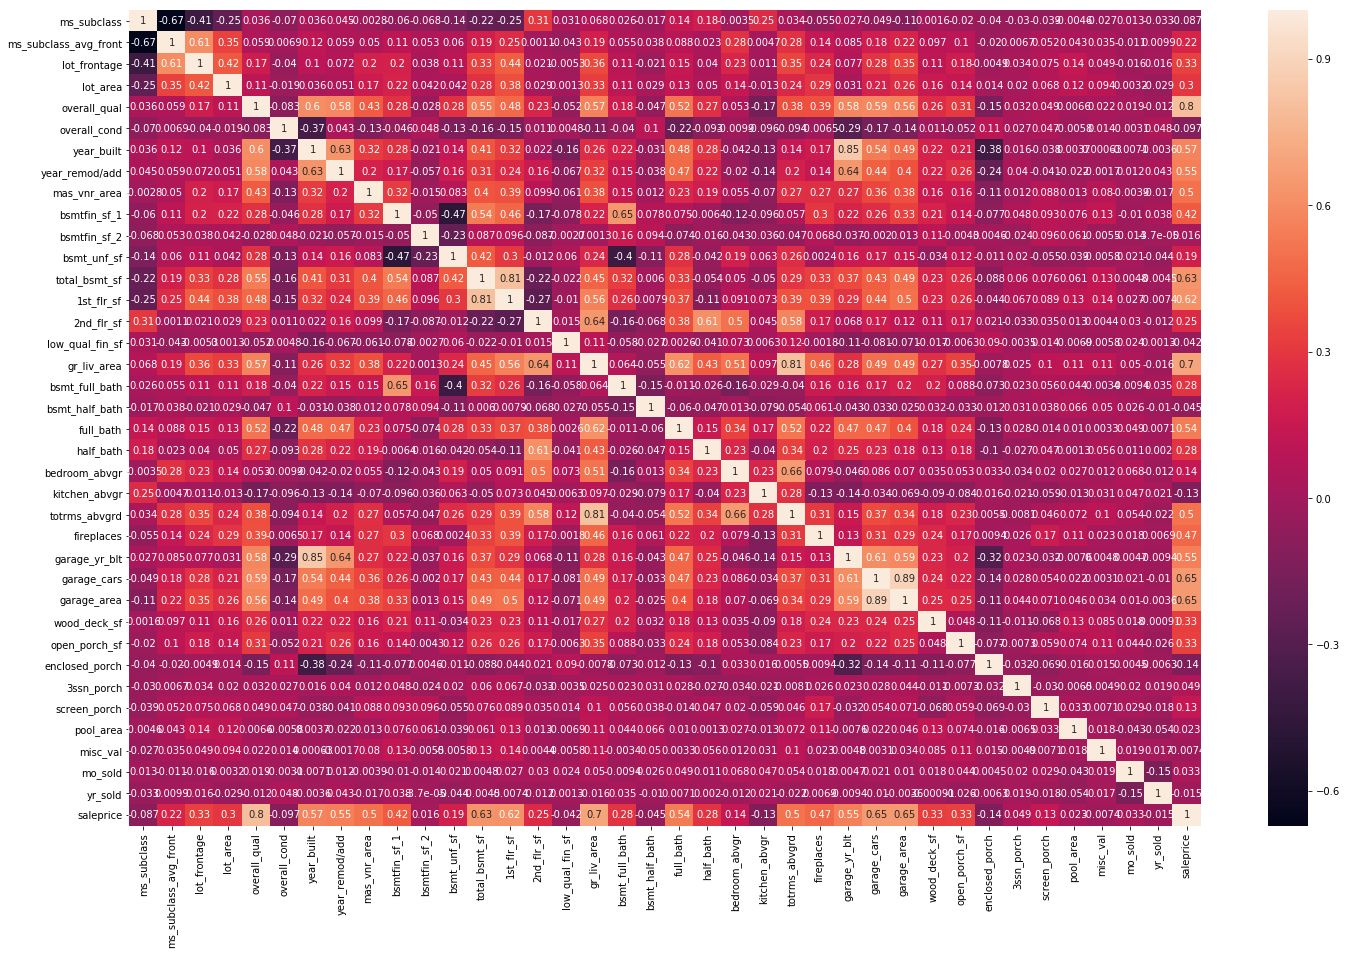

In [54]:
plt.figure(figsize = (24,15))
sns.heatmap(data.corr(), annot=True);
#note, this heatmap is overwhelming and difficult to read at first glance.
#because sale_price is bottom row, we can go across the bottom to read it easier

##### Going to choose some features to make polynomial features manually
##### Our targets for polynomial features will be features that have a high correlation with price, but also have 
##### a high correlation with other features we may want to use.  We're going to eyeball this and make a list.  note that it helps to be on more than one monitor to do this efficiently

In [55]:
#this will return an easy to read column of saleprice correlations
corr = data.corr()

corr_price = abs(corr.saleprice)    #We use absolute value here because we're working with correlations.

corr_price = pd.DataFrame(corr_price)

corr_price = corr_price.sort_values(by='saleprice', ascending=False)

corr_price.head(2)

,saleprice
saleprice,1.000000
overall_qual,0.800207


In [56]:
#Reviewing this weeks later and it's nice to see how differently I would do things now.
#now, we'll save sale price and drop it

saleprice = data.saleprice
data.drop('saleprice', axis=1, inplace=True)

In [57]:
jj = []
for x in data['pool_area']:
    if x > 0:
        jj.append(1)
    else:
        jj.append(0)

data['is_pool'] = np.array(jj)

data[['pool_area', 'is_pool']].head(2)

,pool_area,is_pool
0,0,0
1,0,0


In [58]:
jj = []
for x in test['pool_area']:
    if x > 0:
        jj.append(1)
    else:
        jj.append(0)

test['is_pool'] = np.array(jj)

test[['pool_area', 'is_pool']].head(2)

,pool_area,is_pool
0,0,0
1,0,0


In [59]:
test.is_pool.sum()

4

In [60]:
#everything that has to do with area, everything that has to do with garages, everything to do with rooms
poly_feat = ['gr_liv_area', '1st_flr_sf', 'total_bsmt_sf', 'bsmtfin_sf_1', 'totrms_abvgrd', 'full_bath', 'bsmt_full_bath','half_bath','garage_area','bedroom_abvgr', 'kitchen_abvgr','garage_cars']

In [61]:
#len is 12, how many polys will is make at 2 degrees?  3?
len(poly_feat)

12

In [62]:
data.shape

(2051, 78)

In [63]:
saleprice.dtype

dtype('int64')

In [64]:
poly = PolynomialFeatures(include_bias=False)
X = data[poly_feat]
X_poly = poly.fit_transform(X)  #fit, transform assign to a variable(returns a matrix)

In [65]:
#X.isnull().sum()

In [66]:
X_poly_data = pd.DataFrame(X_poly, columns=poly.get_feature_names(poly_feat))
X_poly_data.shape

(2051, 90)

In [67]:
#going to drop the first 12 columns(they are our original features), then concat to data.
X_poly_data.drop(X_poly_data.columns[:12], axis=1, inplace=True)

In [68]:
data = pd.concat([data, X_poly_data], axis=1)
data.shape

(2051, 156)

In [69]:
data.head(2)   #notice that some product columns created zeros.

,ms_subclass,ms_zoning,ms_subclass_avg_front,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,is_pool,gr_liv_area^2,gr_liv_area 1st_flr_sf,gr_liv_area total_bsmt_sf,gr_liv_area bsmtfin_sf_1,gr_liv_area totrms_abvgrd,gr_liv_area full_bath,gr_liv_area bsmt_full_bath,gr_liv_area half_bath,gr_liv_area garage_area,gr_liv_area bedroom_abvgr,gr_liv_area kitchen_abvgr,gr_liv_area garage_cars,1st_flr_sf^2,1st_flr_sf total_bsmt_sf,1st_flr_sf bsmtfin_sf_1,1st_flr_sf totrms_abvgrd,1st_flr_sf full_bath,1st_flr_sf bsmt_full_bath,1st_flr_sf half_bath,1st_flr_sf garage_area,1st_flr_sf bedroom_abvgr,1st_flr_sf kitchen_abvgr,1st_flr_sf garage_cars,total_bsmt_sf^2,total_bsmt_sf bsmtfin_sf_1,total_bsmt_sf totrms_abvgrd,total_bsmt_sf full_bath,total_bsmt_sf bsmt_full_bath,total_bsmt_sf half_bath,total_bsmt_sf garage_area,total_bsmt_sf bedroom_abvgr,total_bsmt_sf kitchen_abvgr,total_bsmt_sf garage_cars,bsmtfin_sf_1^2,bsmtfin_sf_1 totrms_abvgrd,bsmtfin_sf_1 full_bath,bsmtfin_sf_1 bsmt_full_bath,bsmtfin_sf_1 half_bath,bsmtfin_sf_1 garage_area,bsmtfin_sf_1 bedroom_abvgr,bsmtfin_sf_1 kitchen_abvgr,bsmtfin_sf_1 garage_cars,totrms_abvgrd^2,totrms_abvgrd full_bath,totrms_abvgrd bsmt_full_bath,totrms_abvgrd half_bath,totrms_abvgrd garage_area,totrms_abvgrd bedroom_abvgr,totrms_abvgrd kitchen_abvgr,totrms_abvgrd garage_cars,full_bath^2,full_bath bsmt_full_bath,full_bath half_bath,full_bath garage_area,full_bath bedroom_abvgr,full_bath kitchen_abvgr,full_bath garage_cars,bsmt_full_bath^2,bsmt_full_bath half_bath,bsmt_full_bath garage_area,bsmt_full_bath bedroom_abvgr,bsmt_full_bath kitchen_abvgr,bsmt_full_bath garage_cars,half_bath^2,half_bath garage_area,half_bath bedroom_abvgr,half_bath kitchen_abvgr,half_bath garage_cars,garage_area^2,garage_area bedroom_abvgr,garage_area kitchen_abvgr,garage_area garage_cars,bedroom_abvgr^2,bedroom_abvgr kitchen_abvgr,bedroom_abvgr garage_cars,kitchen_abvgr^2,kitchen_abvgr garage_cars,garage_cars^2
0,60,RL,78.269481,78.269481,13517,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,None,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,None,None,0,3,2010,WD,0,2187441.0,1072275.0,1072275.0,788307.0,8874.0,2958.0,0.0,1479.0,702525.0,4437.0,1479.0,2958.0,525625.0,525625.0,386425.0,4350.0,1450.0,0.0,725.0,344375.0,2175.0,725.0,1450.0,525625.0,386425.0,4350.0,1450.0,0.0,725.0,344375.0,2175.0,725.0,1450.0,284089.0,3198.0,1066.0,0.0,533.0,253175.0,1599.0,533.0,1066.0,36.0,12.0,0.0,6.0,2850.0,18.0,6.0,12.0,4.0,0.0,2.0,950.0,6.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,475.0,3.0,1.0,2.0,225625.0,1425.0,475.0,950.0,9.0,3.0,6.0,1.0,2.0,4.0
1,60,RL,78.269481,43.000000,11492,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,None,None,0,4,2009,WD,0,4502884.0,1937386.0,1937386.0,1351714.0,16976.0,4244.0,2122.0,2122.0,1186198.

##### Now need to do the same for test set

In [70]:
poly = PolynomialFeatures(include_bias=False)  #we don't need this here again  DRY
X = test[poly_feat]
y = saleprice                    #We don't actually need the y in there to make polys, but we'll leave for when we cut/paste later
X_poly = poly.fit_transform(X)  #fit, transform assign to a variable(returns a matrix)

X_poly_test = pd.DataFrame(X_poly, columns=poly.get_feature_names(poly_feat))

X_poly_test.drop(X_poly_test.columns[:12], axis=1, inplace=True)

test = pd.concat([test, X_poly_test], axis=1)
test.shape   #need to end up with 158 columns

(879, 156)

#### Going to make dummies of all categorical columns 

In [71]:
data.head(2)

,ms_subclass,ms_zoning,ms_subclass_avg_front,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,is_pool,gr_liv_area^2,gr_liv_area 1st_flr_sf,gr_liv_area total_bsmt_sf,gr_liv_area bsmtfin_sf_1,gr_liv_area totrms_abvgrd,gr_liv_area full_bath,gr_liv_area bsmt_full_bath,gr_liv_area half_bath,gr_liv_area garage_area,gr_liv_area bedroom_abvgr,gr_liv_area kitchen_abvgr,gr_liv_area garage_cars,1st_flr_sf^2,1st_flr_sf total_bsmt_sf,1st_flr_sf bsmtfin_sf_1,1st_flr_sf totrms_abvgrd,1st_flr_sf full_bath,1st_flr_sf bsmt_full_bath,1st_flr_sf half_bath,1st_flr_sf garage_area,1st_flr_sf bedroom_abvgr,1st_flr_sf kitchen_abvgr,1st_flr_sf garage_cars,total_bsmt_sf^2,total_bsmt_sf bsmtfin_sf_1,total_bsmt_sf totrms_abvgrd,total_bsmt_sf full_bath,total_bsmt_sf bsmt_full_bath,total_bsmt_sf half_bath,total_bsmt_sf garage_area,total_bsmt_sf bedroom_abvgr,total_bsmt_sf kitchen_abvgr,total_bsmt_sf garage_cars,bsmtfin_sf_1^2,bsmtfin_sf_1 totrms_abvgrd,bsmtfin_sf_1 full_bath,bsmtfin_sf_1 bsmt_full_bath,bsmtfin_sf_1 half_bath,bsmtfin_sf_1 garage_area,bsmtfin_sf_1 bedroom_abvgr,bsmtfin_sf_1 kitchen_abvgr,bsmtfin_sf_1 garage_cars,totrms_abvgrd^2,totrms_abvgrd full_bath,totrms_abvgrd bsmt_full_bath,totrms_abvgrd half_bath,totrms_abvgrd garage_area,totrms_abvgrd bedroom_abvgr,totrms_abvgrd kitchen_abvgr,totrms_abvgrd garage_cars,full_bath^2,full_bath bsmt_full_bath,full_bath half_bath,full_bath garage_area,full_bath bedroom_abvgr,full_bath kitchen_abvgr,full_bath garage_cars,bsmt_full_bath^2,bsmt_full_bath half_bath,bsmt_full_bath garage_area,bsmt_full_bath bedroom_abvgr,bsmt_full_bath kitchen_abvgr,bsmt_full_bath garage_cars,half_bath^2,half_bath garage_area,half_bath bedroom_abvgr,half_bath kitchen_abvgr,half_bath garage_cars,garage_area^2,garage_area bedroom_abvgr,garage_area kitchen_abvgr,garage_area garage_cars,bedroom_abvgr^2,bedroom_abvgr kitchen_abvgr,bedroom_abvgr garage_cars,kitchen_abvgr^2,kitchen_abvgr garage_cars,garage_cars^2
0,60,RL,78.269481,78.269481,13517,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,None,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,None,None,0,3,2010,WD,0,2187441.0,1072275.0,1072275.0,788307.0,8874.0,2958.0,0.0,1479.0,702525.0,4437.0,1479.0,2958.0,525625.0,525625.0,386425.0,4350.0,1450.0,0.0,725.0,344375.0,2175.0,725.0,1450.0,525625.0,386425.0,4350.0,1450.0,0.0,725.0,344375.0,2175.0,725.0,1450.0,284089.0,3198.0,1066.0,0.0,533.0,253175.0,1599.0,533.0,1066.0,36.0,12.0,0.0,6.0,2850.0,18.0,6.0,12.0,4.0,0.0,2.0,950.0,6.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,475.0,3.0,1.0,2.0,225625.0,1425.0,475.0,950.0,9.0,3.0,6.0,1.0,2.0,4.0
1,60,RL,78.269481,43.000000,11492,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,None,None,0,4,2009,WD,0,4502884.0,1937386.0,1937386.0,1351714.0,16976.0,4244.0,2122.0,2122.0,1186198.

In [75]:
#data.utilities.value_counts()
data.drop(['utilities', 'heating'], axis=1, inplace=True)

In [76]:
categ_cols = list(data.select_dtypes(include=['object']).columns)

In [77]:
categ_cols.append('yr_sold')

In [78]:
####  This is the right way to get dummies.  
#not going to drop first_value, in case there's a missing value we need to sort out
# we're going to sort out the missing columns after

data = pd.get_dummies(data, columns=categ_cols)
test = pd.get_dummies(test, columns=categ_cols)

data.shape, test.shape

((2051, 371), (879, 359))

In [79]:
#to see which columns didn't have dummies in each set
data_drop = list(set(data.columns) - set(test.columns))

In [80]:
data_drop[:2]

['functional_Sev', 'condition_2_RRNn']

In [81]:
test_drop = list(set(test.columns) - set(data.columns))

In [82]:
data.drop(data[data_drop],  axis=1, inplace=True)

In [83]:
test.drop(test[test_drop],  axis=1, inplace=True)    #Note that this also handled columns dropped only from data earlier

In [84]:
data.shape, test.shape

((2051, 349), (879, 349))

### Now, we'll scale features

In [85]:
# #we need id, and don't want to scale it
# data.set_index('id', inplace=True)
# test.set_index('id', inplace=True)

KeyError: 'id'

In [86]:
test.describe().columns

Index(['ms_subclass', 'ms_subclass_avg_front', 'lot_frontage', 'lot_area',
       'overall_qual', 'overall_cond', 'year_built', 'year_remod/add',
       'mas_vnr_area', 'bsmtfin_sf_1',
       ...
       'sale_type_ConLI', 'sale_type_ConLw', 'sale_type_New', 'sale_type_Oth',
       'sale_type_WD ', 'yr_sold_2006', 'yr_sold_2007', 'yr_sold_2008',
       'yr_sold_2009', 'yr_sold_2010'],
      dtype='object', length=349)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(data, y, random_state=42)

In [88]:
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
test = ss.transform(test)


## Step 4: Model with data

First, do a lassoCV, see which features stay.

In [89]:
#Find alpha
lasso = LassoCV(n_alphas=1000)
model00 = lasso.fit(X_train, y_train)
model00.alpha_, model00

(8820.032809089515,
 LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
     max_iter=1000, n_alphas=1000, n_jobs=1, normalize=False,
     positive=False, precompute='auto', random_state=None,
     selection='cyclic', tol=0.0001, verbose=False))

In [90]:
#This returned a massive alpha

In [91]:
kf = KFold(n_splits = 10, shuffle=True)
lasso = Lasso()
scores = cross_val_score(lasso, X_train, y_train, cv=kf)
scores, scores.mean(), np.var(scores)

/Users/erikgreenj/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/erikgreenj/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/erikgreenj/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/erikgreenj/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: 

(array([0.93377922, 0.64721818, 0.87715009, 0.77680882, 0.92268586,
        0.91995038, 0.77170231, 0.90252268, 0.80732035, 0.86740381]),
 0.8426541699989964,
 0.007488378303640538)

In [92]:
lasso_reg = Lasso(alpha=model00.alpha_)
# lasso_reg.set_params(alpha=model00.alpha_)
lasso_reg.fit(X_train, y_train)
lasso_coefs = lasso_reg.coef_
yyy_hat = lasso_reg.predict(test)

In [93]:
lasso_reg.score(X_test, y_test)

0.8373776417279044

In [94]:
len(lasso_coefs)

349

In [95]:
count=0
for coef in lasso_coefs:
    if coef == 0:
        count += 1
zero_percent = count/len(lasso_coefs)
zero_percent

0.9541547277936963

#### zeroed out 95.4% of coefs

In [96]:
data_lasso_features = list(data.columns)

In [97]:
data_lasso_coefs = pd.DataFrame(
    {'features': data_lasso_features,
     'coefs': lasso_coefs
    })

In [98]:
non_zero = data_lasso_coefs[data_lasso_coefs.coefs != 0]  #created a dataframe of non-zero coefs

In [99]:
pd.DataFrame(list(sorted(zip(lasso_reg.coef_, data.columns)))).head()

,0,1
0,-1351.488617,exter_qual_TA
1,0.000000,1st_flr_sf
2,0.000000,1st_flr_sf bedroom_abvgr
3,0.000000,1st_flr_sf bsmt_full_bath
4,0.000000,1st_flr_sf bsmtfin_sf_1


In [100]:
non_zero.sort_values(by='coefs', ascending=False).head(15)

,features,coefs
4,overall_qual,23568.276619
48,gr_liv_area garage_cars,20035.199535
285,kitchen_qual_Ex,5249.784359
246,bsmt_qual_Ex,4983.714426
63,total_bsmt_sf full_bath,4762.941374
16,gr_liv_area,4619.588390
231,exter_qual_Ex,2357.757511
69,total_bsmt_sf garage_cars,2192.969456
99,bsmt_full_bath garage_cars,1917.977132
7,year_remod/add,1908.641905


### according to LassoCV, these are the most important coefs.  

In [ ]:
rf = RandomForestRegressor()

In [102]:
grid_params = {
    'n_estimators' : [10, 25, 50, 100, 250, 500, 1000],
    'max_features' : [3, 5, 7, 10, 12, 15, 20, 25, 30, 40, 50],
    'max_depth' : [1,3,5,7,10],
    'min_samples_split' : [2, 4, 7, 10, 15]
    
}

gs = GridSearchCV(
    RandomForestRegressor(),
    grid_params,
    verbose = 1,
    n_jobs = -1
)

gs_results = gs.fit(X_train, y_train)

Fitting 3 folds for each of 1925 candidates, totalling 5775 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 223 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 823 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1273 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1823 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2473 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 3223 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 4073 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 5023 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 5775 out of 5775 | elapsed: 15.3min finished


In [103]:
gs.best_params_

{'max_depth': 10,
 'max_features': 50,
 'min_samples_split': 2,
 'n_estimators': 50}

In [104]:
gs.best_score_

0.8706695568413374

In [105]:
y_train_hat = gs.predict(X_train)
print('Multiple regression RMSE:', np.mean(np.square(y_train - y_train_hat)) ** 0.5)

Multiple regression RMSE: 12156.619263692894


In [106]:
y_test_hat = gs.predict(X_test)
print('Multiple regression RMSE:', np.mean(np.square(y_test - y_test_hat)) ** 0.5)

Multiple regression RMSE: 23826.880689472575


In [107]:
test = pd.DataFrame(test)
test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348
0,3.078867,-0.882067,-0.031528,-0.149967,-0.076947,2.218337,-2.050815,-1.633324,-0.558774,-0.945787,-0.283011,1.024727,-0.081786,-0.628024,1.621198,-0.106748,0.848984,-0.811348,-0.24282,0.773523,-0.753468,1.419944,4.761341,1.655306,-0.909232,-2.431424,-1.007186,-0.149301,-0.752985,0.186421,1.496917,-0.100195,-0.285912,-0.065997,-0.093658,-0.807256,-0.067618,0.618006,-0.074716,0.184271,-0.572829,1.134556,0.848360,-0.713199,-0.700519,0.153631,1.284669,3.479869,-0.479886,-0.514153,-0.329108,-0.541648,0.104207,-0.080255,-0.712152,-0.672858,-0.422021,0.192462,1.184889,-0.872775,-0.186917,-0.470567,0.480719,0.258199,-0.677047,-0.655956,-0.206702,0.662753,1.782350,-0.665932,-0.387771,-0.749888,-0.791665,-0.572495,-0.437226,-0.625590,-0.908333,-0.919454,-0.747117,1.670578,1.347611,-0.763966,-0.722120,0.417206,1.802046,4.275920,-0.406499,0.678356,-0.703917,-0.687072,0.170480,1.385019,3.114240,-0.510601,-0.656531,-0.374518,-0.695049,-0.747018,-0.754033,-0.709776,-0.681450,-0.677177,-0.707971,-0.712520,-0.689179,-0.333622,0.528969,1.576111,-0.739809,1.450359,3.855316,-0.374925,4.710906,0.184727,-1.017786,-0.095845,-0.240357,0.0,-0.088677,-1.856094,2.360646,-0.05711,0.05711,-0.718864,-0.157004,-0.067618,0.765224,-0.203224,-0.211747,-0.143425,0.338368,-0.445817,-0.255141,-0.175588,-0.051064,0.591868,0.221615,-0.210066,-0.067618,-0.11184,-0.05711,-0.095845,-0.204952,-0.114783,-0.31271,-0.183309,-0.269304,-0.247834,-0.036084,-0.19258,-0.108821,-0.201483,-0.408558,-0.099242,-0.226417,-0.159164,-0.240357,3.551143,-0.117657,-0.244865,-0.216727,-0.27207,-0.138629,-0.148077,-0.080898,-0.181406,-0.232694,0.402034,-0.080898,-0.11184,-0.10253,-0.145768,-0.044209,-0.062582,-0.080898,0.120465,-0.044209,-0.036084,-2.206860,6.369267,-0.181406,-0.187065,-0.296133,-0.345484,-0.07231,-1.037099,-0.044209,-0.080898,1.545207,-0.161299,-0.206668,-0.080898,0.511556,-0.076722,-0.486142,-0.051064,-0.036084,0.117657,-0.088677,-0.051064,-0.044209,7.779460,-0.025507,-0.036084,-0.159164,-0.216727,-0.415037,-0.434238,-0.282942,-0.114783,-0.741892,-0.404214,-0.145768,8.941329,-0.036084,-0.095845,-0.117657,-0.036084,-0.216727,-0.392159,-0.076722,-0.43,-0.312710,-0.123213,-0.741892,-0.388841,-0.175588,-0.084874,-0.671523,0.807457,-0.288268,-0.196182,-0.114783,-0.717824,0.799787,-0.05711,6.369267,-0.33956,-0.036084,-2.564440,-0.346662,-0.846474,-0.916359,-0.123213,17.509997,-0.025507,-0.307672,5.695154,-0.868162,-0.163408,-0.025507,-0.863564,-0.177546,-0.221615,-0.163408,0.347838,-0.402034,-0.32386,-0.288268,0.715745,-0.169595,-0.398755,-0.327523,-0.668467,-0.224825,-0.163408,-0.317696,1.559819,-0.125905,-0.154816,-0.10253,-0.181406,-0.165494,-0.194388,0.410723,-1.02502,-0.19258,2.342958,-0.648174,3.675518,-3.

In [111]:
SalePrice = gs.predict(test)

submission = pd.DataFrame(testindex)

submission['SalePrice'] = SalePrice

submission.columns = (['id', 'SalePrice'])

submission.set_index('id', inplace=True)

submission.to_csv('submission99.csv')

In [112]:
submission.head()

,SalePrice
id,
0,140129.641220
1,172570.694938
2,172758.894784
3,120149.998808
4,171415.830205
